In [1]:
from google.colab import files
up = files.upload()

Saving DailyDelhiClimateTest.csv to DailyDelhiClimateTest.csv


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import levene
from plotnine import ggplot, aes, geom_boxplot, labs, theme_minimal
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
import scipy.stats as stats
from sklearn.metrics import mean_absolute_percentage_error





DailyDelhiClimateTrain = pd.read_csv("DailyDelhiClimateTrain.csv")
DailyDelhiClimateTest  = pd.read_csv("DailyDelhiClimateTest.csv")

Entreno = DailyDelhiClimateTrain.copy(deep=True)
Testeo  = DailyDelhiClimateTest.copy(deep=True)


In [3]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np

# ---------- TRAIN ----------
# Creamos una copia del DataFrame de entrenamiento para no modificar el original
df_temp_diaria = DailyDelhiClimateTrain.copy()
# Generamos una secuencia de fechas diarias iniciando en 2013-01-01 con el mismo número de filas que el DataFrame
df_temp_diaria["date"] = pd.date_range(start="2013-01-01", periods=len(DailyDelhiClimateTrain), freq="D")

# A partir de las fechas diarias, creamos la columna 'semana' pisando cada fecha al inicio de su semana (anclaje W-SUN)
df_temp_semanal = (
    df_temp_diaria
      # Calculamos la semana como periodo semanal y tomamos el inicio de esa semana (nota: usamos .dt.start_time)
      .assign(semana=df_temp_diaria["date"].dt.to_period("W-SUN").dt.start_time)
      # Agrupamos por semana
      .groupby("semana", as_index=False)
      # Calculamos el promedio de la temperatura media, ignorando NAs
      .agg(mean_temp=("meantemp", lambda x: np.nanmean(x)))
)

# Construimos una Serie temporal semanal con índice de fechas (inicio de semana) y valores 'mean_temp'
ts_temp_semanal = pd.Series(
    df_temp_semanal["mean_temp"].to_numpy(),
    index=pd.DatetimeIndex(df_temp_semanal["semana"])
)

# ---------- TEST ----------
# Creamos una copia del DataFrame de prueba para no modificar el original
df_temp_diaria_test = DailyDelhiClimateTest.copy()
# Generamos una secuencia de fechas diarias iniciando en 2017-01-01 con el mismo número de filas que el DataFrame de prueba
df_temp_diaria_test["date"] = pd.date_range(start="2017-01-01", periods=len(DailyDelhiClimateTest), freq="D")

# Repetimos el mismo proceso para el conjunto de prueba: calcular semana y promedio semanal de 'meantemp'
df_temp_semanal_test = (
    df_temp_diaria_test
      # Columna 'semana' a partir del periodo semanal y su inicio (nota: usamos .dt.start_time)
      .assign(semana=df_temp_diaria_test["date"].dt.to_period("W-SUN").dt.start_time)
      # Agrupamos por semana
      .groupby("semana", as_index=False)
      # Promedio semanal de la temperatura media
      .agg(mean_temp=("meantemp", lambda x: np.nanmean(x)))
)

# Serie temporal semanal para el conjunto de prueba, con índice de fechas (inicio de semana)
ts_temp_semanal_test = pd.Series(
    df_temp_semanal_test["mean_temp"].to_numpy(),
    index=pd.DatetimeIndex(df_temp_semanal_test["semana"])
)


In [4]:
# Concatenar las dos series temporales en un DataFrame
df_combinado = pd.concat([ts_temp_semanal.rename("Train"), ts_temp_semanal_test.rename("Test")], axis=1)

# Mostrar el DataFrame combinado
display(df_combinado)

,Train,Test
semana,,
2012-12-31,7.705556,NaN
2013-01-07,12.343537,NaN
2013-01-14,13.642857,NaN
2013-01-21,12.329592,NaN
2013-01-28,15.736905,NaN
...,...,...
2017-03-27,NaN,30.203515
2017-04-03,NaN,28.805189
2017-04-10,NaN,29.820862


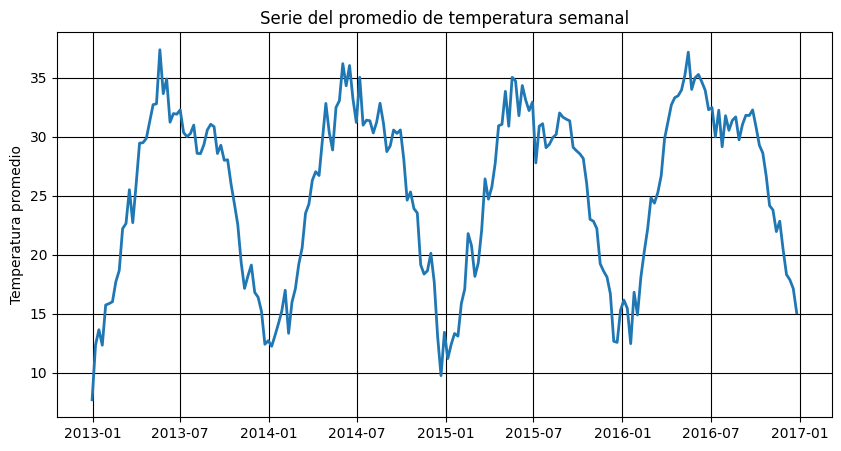

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(ts_temp_semanal.index, ts_temp_semanal.values, linewidth=2)
plt.ylabel("Temperatura promedio")
plt.title("Serie del promedio de temperatura semanal")
plt.grid(color="black")
plt.show()

##GRAFICAMENTE OBSERVAMOS QUE SE PRESENTA UNA ESTACIONALIDAD CADA ANO APROXIMADAMENTE Y UNA VARIANZA APROXIMADAMENTE
##CONSTANTE POR LO QUE NO APLICAREMOS UNA TRANSFOMRACION DE BOX COX

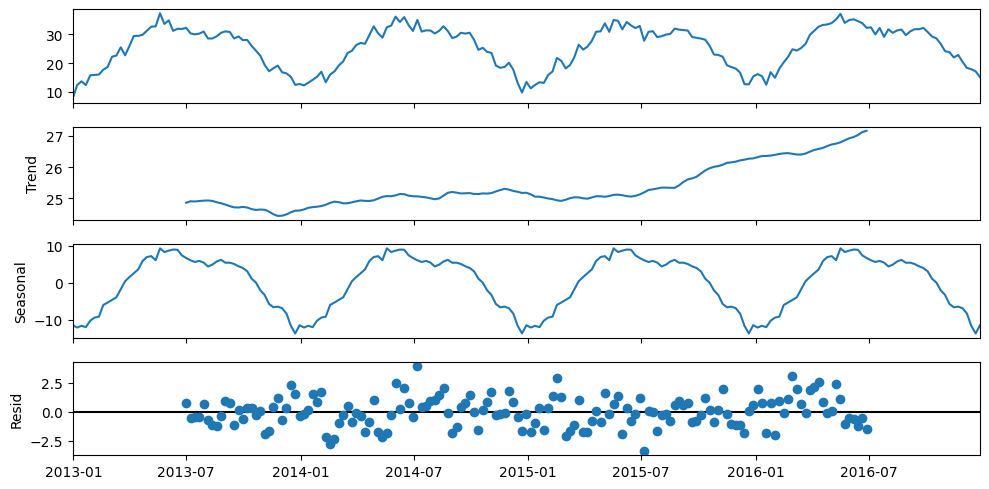

In [6]:
##OBSERVEMOS UNA DESCOMPOSICION ADITIVA CON EL FIN DE TENER INDICIOS SOBRE LA ESTACIONALIDAD Y
##LA POSIBLE TENDENCIA DE LA SERIE

# Descomposición aditiva
descomp = seasonal_decompose(ts_temp_semanal, model="additive", period=52)

# Graficar

fig = descomp.plot()
fig.set_size_inches(10, 5)
plt.tight_layout()
plt.show()

##OBSERVAMOS UNA CLARA ESTACIONALIDAD ADEMAS DE OBSERVAR UNA TENDENCIA A LA ALZA POR PARTE DE LA SERIE,
##POR LO QUE PODRIAMOS ESPERAR QUE LA TEMPERATURA MEDIA SEMANAL ESTE AUMENTANDO, ESTO PUEDE
##DEVERSE A DIFERENTES FACTORES, COMO POSIBLES DE ELLOS EL CALENTAMIENTO GLOBAL

In [7]:
resultado_adf = adfuller(ts_temp_semanal.dropna())
print(f"ADF Statistic: {resultado_adf[0]}")
print(f"p-value: {resultado_adf[1]}")

ADF Statistic: -4.745758091420331
p-value: 6.898378388762748e-05


COMO EL VALOR P ES MENOR A 0.05 RECHAZAMOS H0 Y POR LO QUE LA SERIE ES ESTACIONARIA.

In [8]:
# AHORA MIREMOS LA PRUEBA DE HOMOGENEIDAD DE VARIANZAS DE LEVEANE,
segmentos = pd.cut(np.arange(1, len(ts_temp_semanal) + 1), bins=52)
grupos = [ts_temp_semanal[segmentos == c].values for c in segmentos.categories]
pl = levene(*grupos, center="median")
print(pl)

LeveneResult(statistic=np.float64(1.2345695688238065), pvalue=np.float64(0.16432977483815764))


OBSERVAMOS QUE RECHAZAMOS H0, POR LO QUE HAY HOMOGENEIDAD DE VARIANZAS DE FORMA ANUAL, LO QUE SE EVIDENCIA EN EL GRAFICO PUES HAY UN GRAN PARECIDO EN LA SERIE TODOS LOS AÑOS

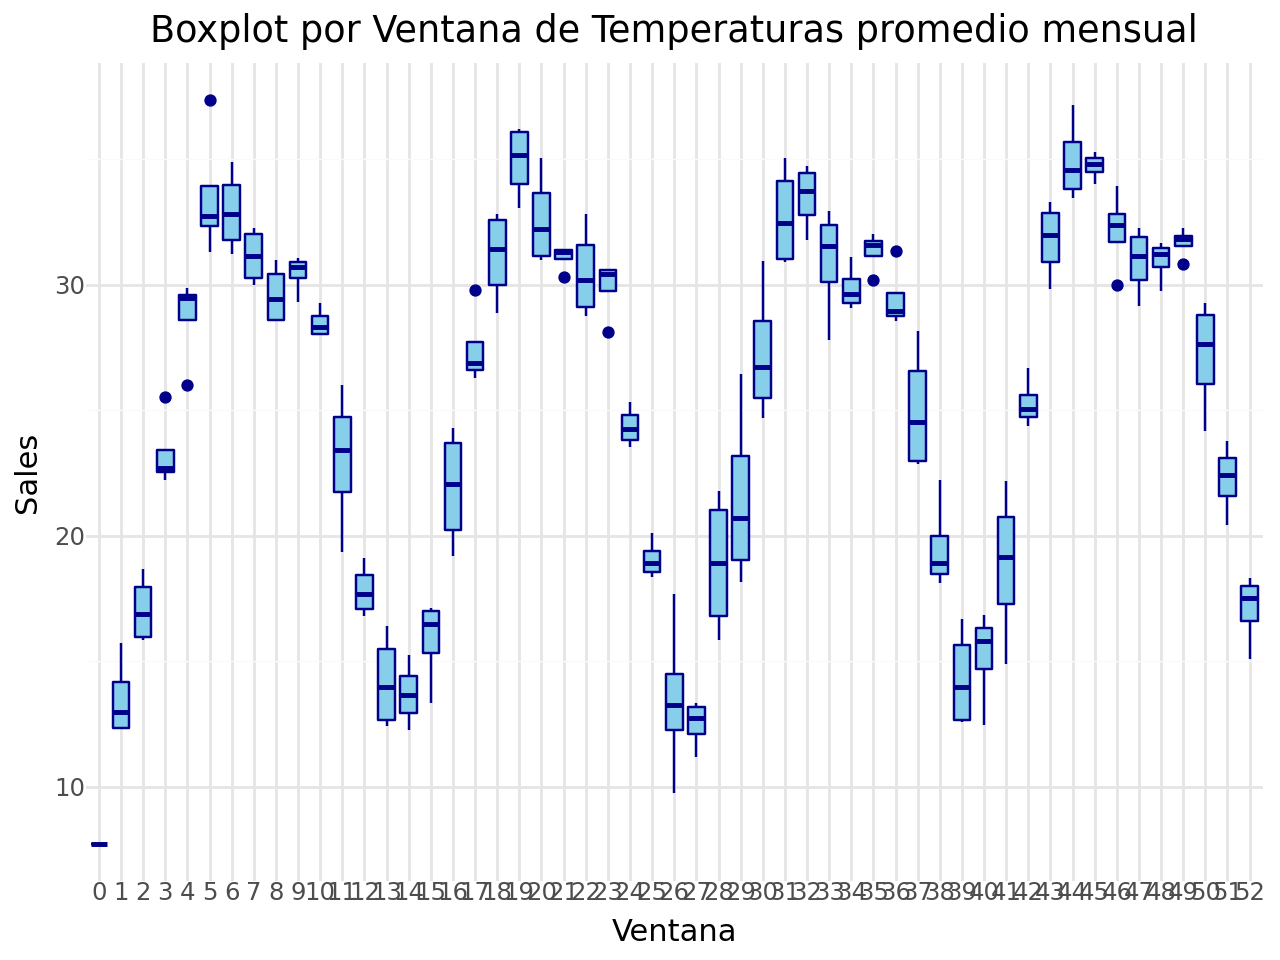

In [9]:
# BOXPLOTS MENSUALES

fechas = pd.date_range(start="2013-01-01", periods=len(ts_temp_semanal), freq="W")
datos = pd.DataFrame({"Fecha": fechas, "Valor": ts_temp_semanal.values})
tamaño_ventana = 4  # TOMAR UNA VENTANA MAS ALTA, POR EJEMPLO 30, TRIMESTRAL,SEMESTRAL
datos = datos.assign(
    Semana=(datos["Fecha"] - datos["Fecha"].min()) / np.timedelta64(1, "W"),
)
datos["Ventana"] = np.ceil(datos["Semana"] / tamaño_ventana).astype(int)
datos["Ventana"] = datos["Ventana"].astype("category")

(
    ggplot(datos, aes(x="Ventana", y="Valor"))
    + geom_boxplot(fill="skyblue", color="darkblue")
    + labs(
        title="Boxplot por Ventana de Temperaturas promedio mensual",
        x="Ventana",
        y="Sales",
    )
    + theme_minimal()
)

SE OBSERVA COMPORTAMIENTO EN COMPARATIVA DE BOXPLOTS ANUALES MUY PARECIDO

<Figure size 640x480 with 0 Axes>

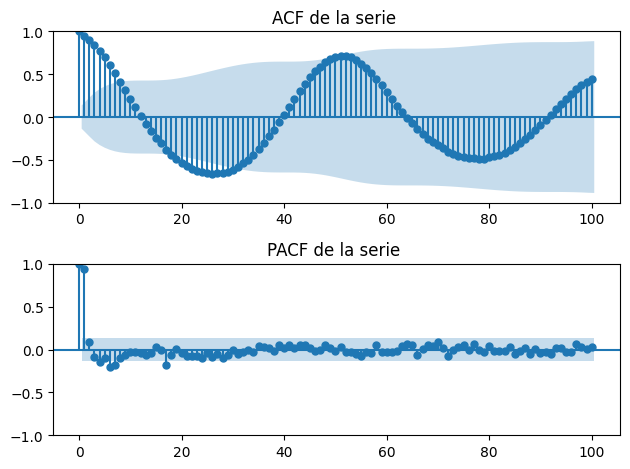

In [10]:
plt.figure()
fig, axes = plt.subplots(2, 1, figsize=(6.4, 4.8))  # equivalente a par(mfrow=c(2,1))
plot_acf(ts_temp_semanal, lags=100, ax=axes[0], title="ACF de la serie ")
plot_pacf(ts_temp_semanal, lags=100, ax=axes[1], title="PACF de la serie ")
plt.tight_layout()
plt.show()

Ahora, en la ACF hay un evidente decaimiento lento en los rezagos con un comportamiento
oscilante, lo que nuevamente nos da un indicio de la estacionalidad de la serie, as ́ı como de
la posible necesidad de diferenciaci ́on. En la PACF observamos un rezago significativo; sin
embargo, no podr ́ıamos interpretarlo con claridad, pues estos gr ́aficos no se ajustan a un
modelo AR ni a un modelo MA.

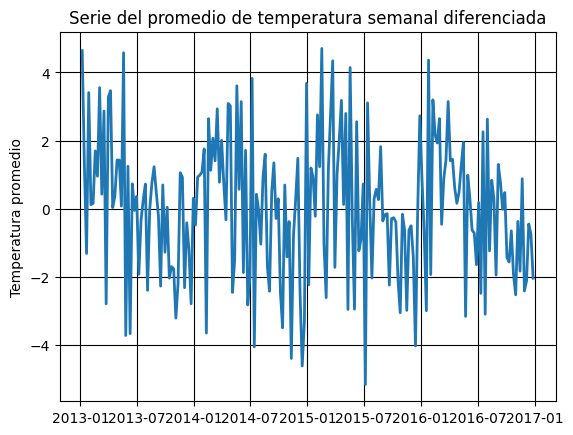

In [11]:
# Diferenciación de la serie
ts_temp_semanal_dif = ts_temp_semanal.diff()

# Gráfico de la serie diferenciada
plt.figure()
plt.plot(ts_temp_semanal_dif.index, ts_temp_semanal_dif.values, linewidth=2)
plt.ylabel("Temperatura promedio")
plt.title("Serie del promedio de temperatura semanal diferenciada")
plt.grid(color="black")
plt.show()

AHORA CON LA PRIMERA DIFERENCIA OBSERVAMOS QUE PRESENTA UNA PATRON ESTACIONARIO

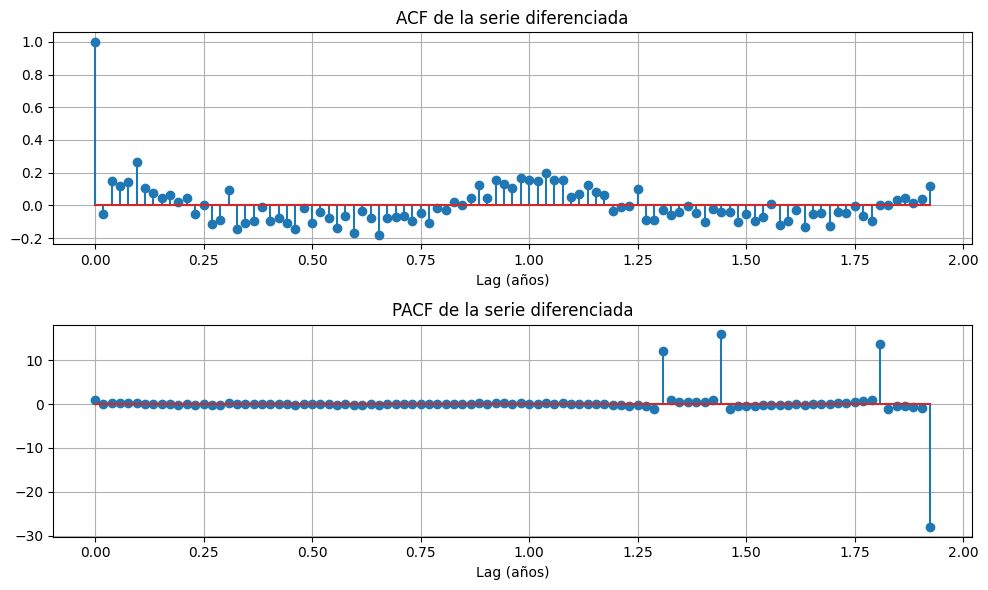

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

# Calcular acf y pacf manualmente para controlar el eje
from statsmodels.tsa.stattools import acf, pacf
acf_vals = acf(ts_temp_semanal_dif.dropna(), nlags=100)
pacf_vals = pacf(ts_temp_semanal_dif.dropna(), nlags=100)

lags = np.arange(len(acf_vals)) / 52  # Escalar lags por frecuencia (52)

axes[0].stem(lags, acf_vals)
axes[0].set_title("ACF de la serie diferenciada")
axes[0].set_xlabel("Lag (años)")
axes[0].grid(True)

axes[1].stem(lags, pacf_vals)
axes[1].set_title("PACF de la serie diferenciada")
axes[1].set_xlabel("Lag (años)")
axes[1].grid(True)

plt.tight_layout()
plt.show()

Se gr ́afica nuevamente la ACF con la tendencia eliminada, y se puede ver un decaimiento
lento cada 52 semanas. En cuando a la PACF las conclusiones estar ́ıan sesgadas ya que los
gr ́aficos no se ajustan a un modelo AR o MA.

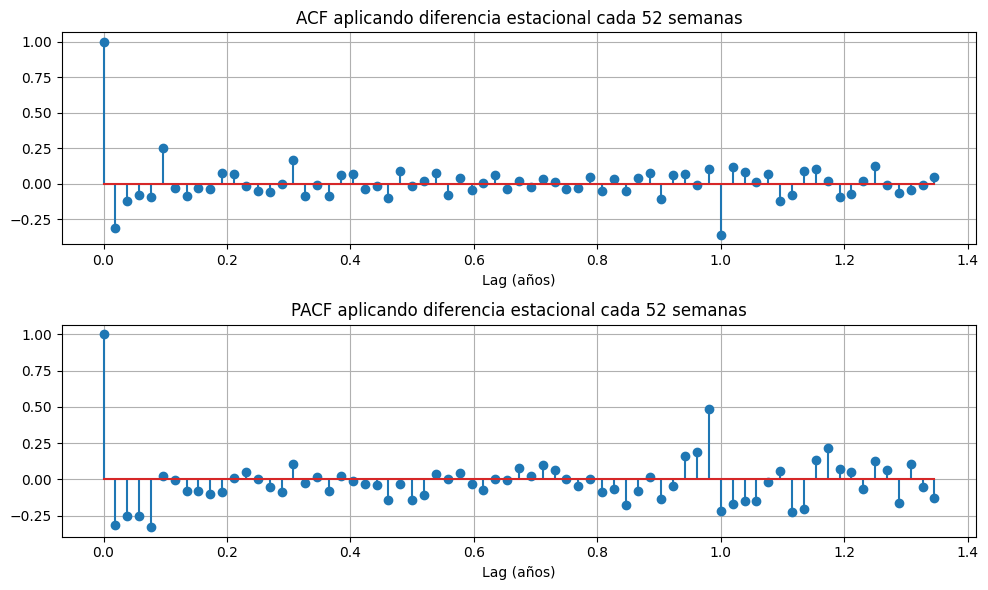

In [13]:
# APLICAMOS LA DIFERENCIACIÓN ESTACIONAL (lag = 52)
ts_temp_semanal_dif_est = ts_temp_semanal_dif.diff(52).dropna()

# Calculamos ACF y PACF hasta 100 rezagos (ajustado por el error anterior)
acf_vals  = acf(ts_temp_semanal_dif_est, nlags=70)
pacf_vals = pacf(ts_temp_semanal_dif_est, nlags=70, method="yw")

# Escalamos el eje de rezagos por la frecuencia (52) para equivalencia con R
lags = np.arange(len(acf_vals)) / 52.0

# Graficamos ACF y PACF con el mismo estilo que R
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.stem(lags, acf_vals)
plt.title("ACF aplicando diferencia estacional cada 52 semanas")
plt.xlabel("Lag (años)")
plt.grid(True)

plt.subplot(2, 1, 2)
plt.stem(lags, pacf_vals)
plt.title("PACF aplicando diferencia estacional cada 52 semanas")
plt.xlabel("Lag (años)")
plt.grid(True)

plt.tight_layout()
plt.show()

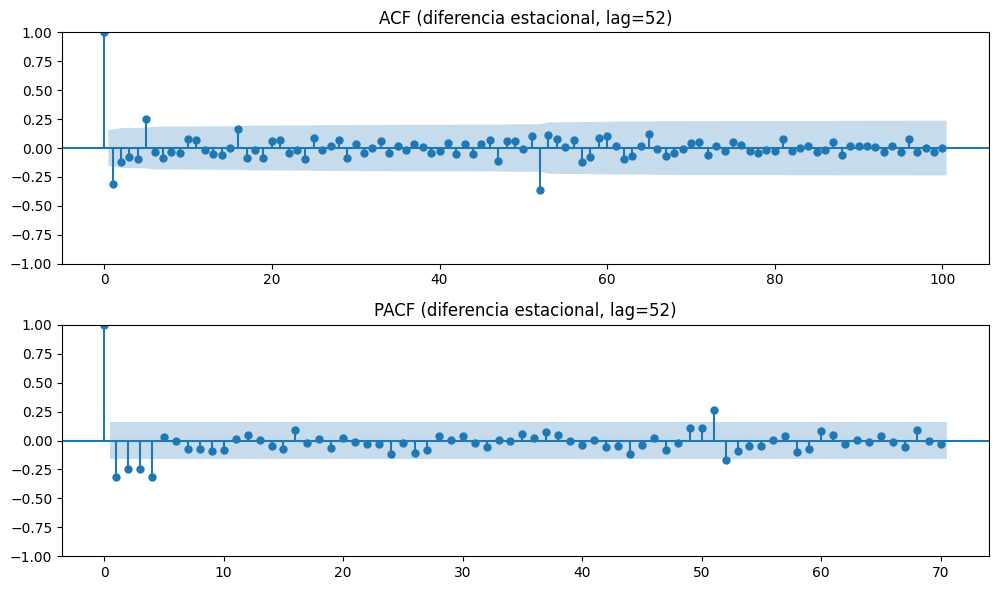

In [14]:

y = ts_temp_semanal.copy()


y_d = y.diff().dropna()


y_ds = y_d.diff(52).dropna()

fig, axes = plt.subplots(2, 1, figsize=(10, 6))
plot_acf(y_ds, lags=100, ax=axes[0], title="ACF (diferencia estacional, lag=52)")
plot_pacf(y_ds, lags=70, ax=axes[1], title="PACF (diferencia estacional, lag=52)", method="ywm")
plt.tight_layout()
plt.show()

Ahora para la componente estacional, en la ACF se muestran un pico significativo en

el rezago 52, el cual equivale a 52 semanas. Para la PACF, se evidencia un comportamien-
to de ca ́ıda aproximadamente exponencial, lo que indica una componente MA(1) para la parte estacional del modelo. Lo anterior implica que el procedimiento que se realiz ́o con las diferenciaciones coincidieron con las sospechas iniciales

SELECCIÓN DEL MODELO POR CRITERIOS AIC Y BIC

In [57]:
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = q = P = Q = 1
d = D = 1
S = 52

rows = []
for i in range(p+1):
    for j in range(q+1):
        for s in range(P+1):
            for m in range(Q+1):
                print(f"({i},{d},{j})x({s},{D},{m})[{S}]")
                try:
                    res = SARIMAX(
                        ts_temp_semanal,
                        order=(i,d,j),
                        seasonal_order=(s,D,m,S),
                        trend="n",
                        enforce_stationarity=True,
                        enforce_invertibility=True,
                        concentrate_scale=False
                    ).fit(method="lbfgs", disp=False, maxiter=1000)
                    rows.append([i,j,s,m,res.aic,res.bic])
                except Exception as e:
                    rows.append([i,j,s,m,np.nan,np.nan])

ic_mod = np.array(rows, dtype=float)
# ordenar por AIC
ic_mod_ordenado = ic_mod[~np.isnan(ic_mod[:,4])][np.argsort(ic_mod[~np.isnan(ic_mod[:,4])][:,4])]
print(["p","q","P","Q","AIC","BIC"])
print(ic_mod_ordenado)



(0,1,0)x(0,1,0)[52]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.


(0,1,0)x(0,1,1)[52]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.


(0,1,0)x(1,1,0)[52]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.


(0,1,0)x(1,1,1)[52]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.


(0,1,1)x(0,1,0)[52]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.


(0,1,1)x(0,1,1)[52]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.


(0,1,1)x(1,1,0)[52]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.


(0,1,1)x(1,1,1)[52]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.


(1,1,0)x(0,1,0)[52]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.


(1,1,0)x(0,1,1)[52]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.


(1,1,0)x(1,1,0)[52]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.


(1,1,0)x(1,1,1)[52]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.


(1,1,1)x(0,1,0)[52]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.


(1,1,1)x(0,1,1)[52]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.


(1,1,1)x(1,1,0)[52]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.


(1,1,1)x(1,1,1)[52]


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.


['p', 'q', 'P', 'Q', 'AIC', 'BIC']
[[  1.           1.           0.           1.         655.67258954
  667.87201356]
 [  1.           1.           1.           1.         657.64156711
  672.89084715]
 [  0.           1.           0.           1.         659.97681278
  669.1263808 ]
 [  0.           1.           1.           1.         661.81639056
  674.01581459]
 [  1.           1.           1.           0.         670.26791642
  682.46734045]
 [  0.           1.           1.           0.         674.65747405
  683.80704208]
 [  1.           0.           0.           1.         689.02242301
  698.17199104]
 [  1.           0.           1.           1.         690.82711542
  703.02653945]
 [  1.           1.           0.           0.         697.5866927
  706.73626072]
 [  0.           1.           0.           0.         704.62577586
  710.72548787]
 [  0.           0.           0.           1.         704.70755161
  710.80726362]
 [  1.           0.           1.           0.        

AJUSTAMOS EL MODELO SELECCIONADO

In [15]:
mod_sel = SARIMAX(
    ts_temp_semanal,                     # la serie semanal (no diferenciada)
    order=(1, 1, 1),
    seasonal_order=(0, 1, 1, 52),
    trend="n",
    enforce_stationarity=True,
    enforce_invertibility=True,
    concentrate_scale=False
).fit(method="lbfgs", disp=False, maxiter=1000)

print("AIC:", mod_sel.aic, "BIC:", mod_sel.bic)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.


AIC: 655.6725895352836 BIC: 667.8720135642817


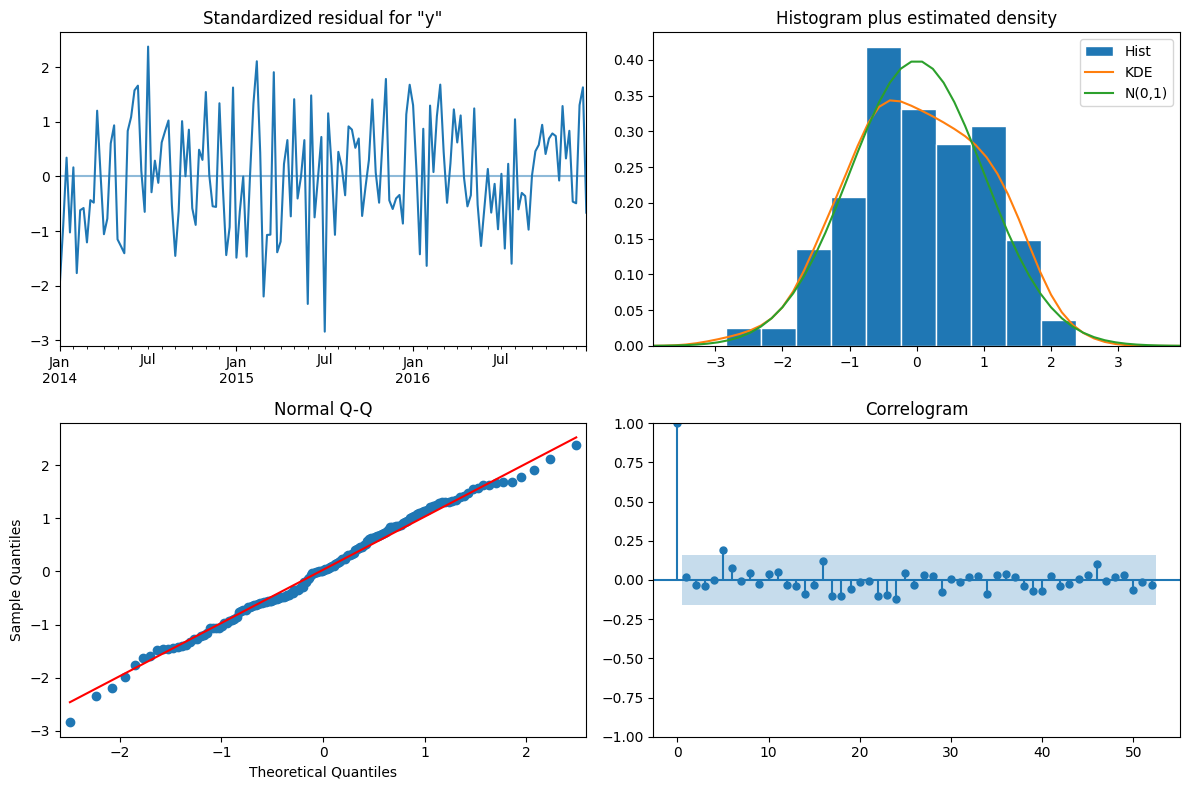

In [17]:
# === 1) Diagnósticos integrados (residuales estandarizados, hist+KDE, Q-Q, ACF) ===
fig = mod_sel.plot_diagnostics(lags=52, figsize=(12, 8))
plt.tight_layout()
plt.show()






In [18]:
res_mod = mod_sel.resid.dropna()

# Misma configuración que R: lag = 1, df = 1 (sin restar parámetros)
lb_r_equiv = acorr_ljungbox(res_mod, lags=[1], return_df=True)
print(lb_r_equiv)

    lb_stat  lb_pvalue
1  1.862494   0.172337


USANDO UN NIVEL DE SIGNIFICANCIA DEL 0.05 OBSERVAMOS QUE NO RECHAMOS H0 ES DECIR, NO TENEMOS RESIDUALES AUTOCORRELACIONADOS

In [20]:
acorr_ljungbox(res_mod, lags=[1], return_df=True)

,lb_stat,lb_pvalue
1,1.862494,0.172337


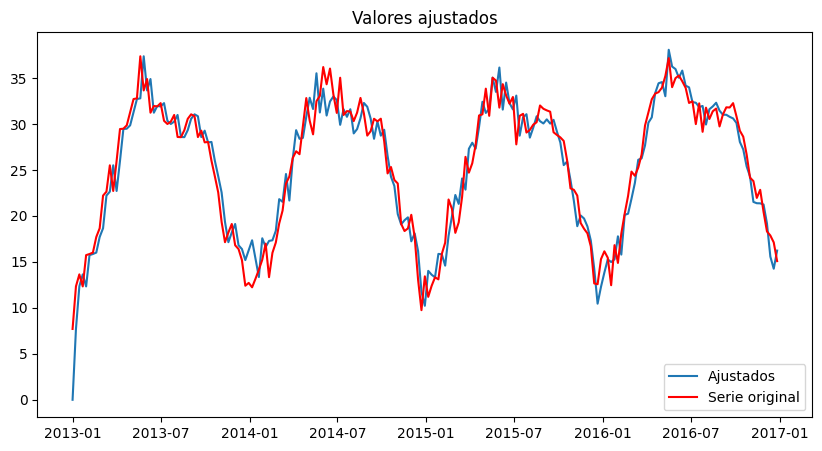

In [22]:
# Gráfico para los valores ajustados
plt.figure(figsize=(10, 5))
plt.plot(ts_temp_semanal.index, mod_sel.fittedvalues, label="Ajustados")
plt.plot(ts_temp_semanal.index, ts_temp_semanal.values, color="red", label="Serie original")
plt.title("Valores ajustados")
plt.legend()
plt.show()

OBSERVAMOS A GRANDES RAZGOS QUE LOS RESIDUALES NO ESTAN CORRELACIONADOS Y QUE EL MODELO APUNTA MUY BIEN PUES AL MIRAR LOS VALORES AJUSTADOS COMPARADOS CON LA SERIE REAL PARECE HABER UN BUEN COMPORTAMIENTO

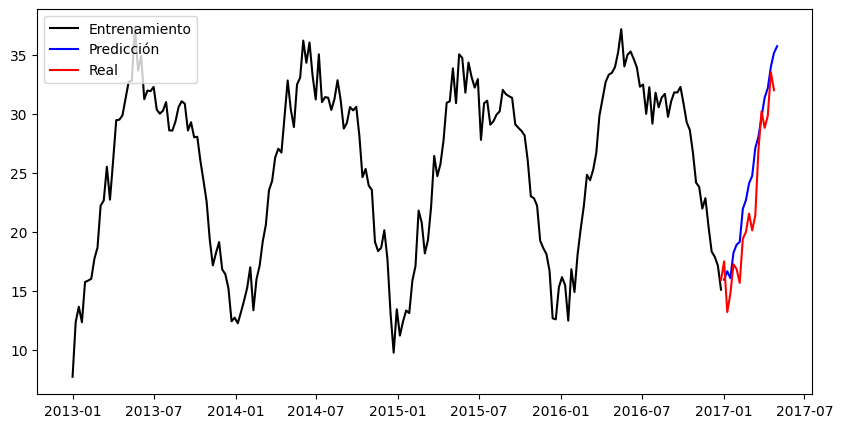

In [23]:
h = len(ts_temp_semanal_test)
predicciones = mod_sel.forecast(steps=h)

plt.figure(figsize=(10, 5))
plt.plot(ts_temp_semanal.index, ts_temp_semanal.values, color="black", label="Entrenamiento")
plt.plot(predicciones.index, predicciones.values, color="blue", label="Predicción")
plt.plot(ts_temp_semanal_test.index, ts_temp_semanal_test.values, color="red", label="Real")
plt.legend(loc="upper left")
plt.show()

AHORA MIREMOS EL MAPE

In [24]:
# Longitud mínima común
longitud = min(len(predicciones), len(ts_temp_semanal_test))

# Calcular MAPE (Mean Absolute Percentage Error)
mape = np.mean(np.abs((ts_temp_semanal_test.values[:longitud] - predicciones.values[:longitud]) /
                      ts_temp_semanal_test.values[:longitud])) * 100

print(f"MAPE del modelo (%): {mape:.2f}")

MAPE del modelo (%): 16.03


AHORA MIREMOS EL AGREGAR VARIABLES EXOGENAS

In [25]:
X_train = Entreno[["humidity", "wind_speed", "meanpressure"]].to_numpy()
X_test  = Testeo[["humidity", "wind_speed", "meanpressure"]].to_numpy()

# === CONVERTIMOS LAS EXÓGENAS A VALORES SEMANALES ===
Entreno["date"] = pd.to_datetime(Entreno["date"])  # asegurar formato fecha

Entreno_semanal = (
    Entreno
    .assign(semana=Entreno["date"].dt.to_period("W-SUN").dt.start_time)
    .groupby("semana", as_index=False)
    .agg({
        "humidity": "mean",
        "wind_speed": "mean",
        "meanpressure": "mean"
    })
)

Testeo["date"] = pd.to_datetime(Testeo["date"])  # asegurar formato fecha

Testeo_semanal = (
    Testeo
    .assign(semana=Testeo["date"].dt.to_period("W-SUN").dt.start_time)
    .groupby("semana", as_index=False)
    .agg({
        "humidity": "mean",
        "wind_speed": "mean",
        "meanpressure": "mean"
    })
)

# === SERIES DE TIEMPO SEMANALES DE VARIABLES EXÓGENAS ===
# Usamos pandas.Series con índice semanal (equivalente a ts() en R)
ts_humedad_semanal = pd.Series(
    Entreno_semanal["humidity"].values,
    index=pd.DatetimeIndex(Entreno_semanal["semana"]),
    name="humidity"
)

ts_velocidad_viento_semanal = pd.Series(
    Entreno_semanal["wind_speed"].values,
    index=pd.DatetimeIndex(Entreno_semanal["semana"]),
    name="wind_speed"
)

ts_presion_media_semanal = pd.Series(
    Entreno_semanal["meanpressure"].values,
    index=pd.DatetimeIndex(Entreno_semanal["semana"]),
    name="meanpressure"
)



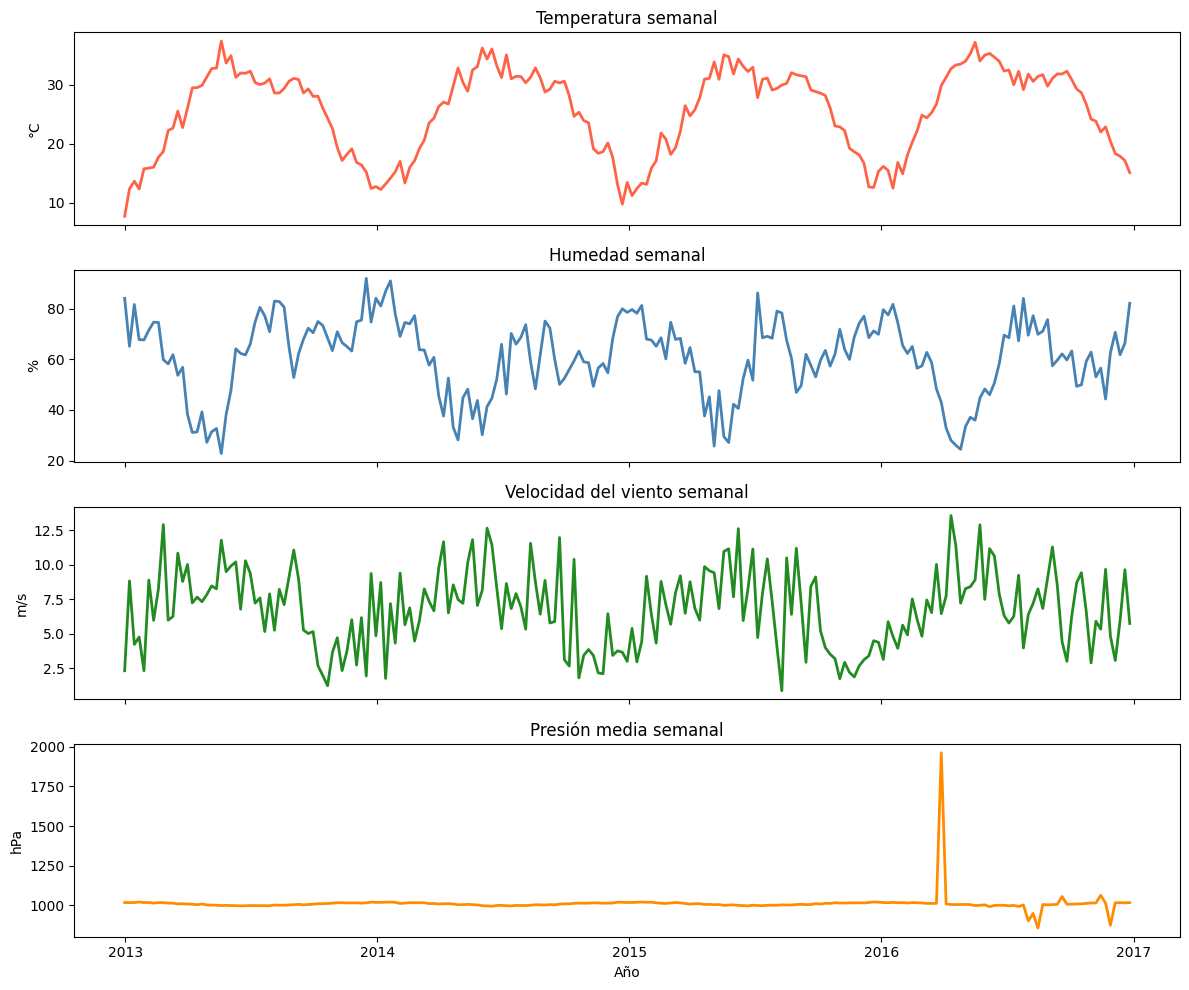

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Configurar formateo del eje X por AÑOS
year_locator = mdates.YearLocator()                 # marca mayor cada año
year_fmt     = mdates.DateFormatter("%Y")           # mostrar solo el año

fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
plt.subplots_adjust(hspace=0.4)

# Temperatura semanal
axes[0].plot(ts_temp_semanal.index, ts_temp_semanal.values, color="tomato", linewidth=2)
axes[0].set_title("Temperatura semanal")
axes[0].set_ylabel("°C")

# Humedad semanal
axes[1].plot(ts_humedad_semanal.index, ts_humedad_semanal.values, color="steelblue", linewidth=2)
axes[1].set_title("Humedad semanal")
axes[1].set_ylabel("%")

# Velocidad del viento semanal
axes[2].plot(ts_velocidad_viento_semanal.index, ts_velocidad_viento_semanal.values, color="forestgreen", linewidth=2)
axes[2].set_title("Velocidad del viento semanal")
axes[2].set_ylabel("m/s")

# Presión media semanal
axes[3].plot(ts_presion_media_semanal.index, ts_presion_media_semanal.values, color="darkorange", linewidth=2)
axes[3].set_title("Presión media semanal")
axes[3].set_xlabel("Año")
axes[3].set_ylabel("hPa")

# Aplicar ticks y formato de años al eje x (a todos por sharex=True)
for ax in axes:
    ax.xaxis.set_major_locator(year_locator)
    ax.xaxis.set_major_formatter(year_fmt)
    ax.tick_params(axis="x", rotation=0)

plt.tight_layout()
plt.show()


Se observa en el gr ́afico de las cuatro series de tiempo que todas presentan una posible estacionalidad, con excepción de la serie asociada a la presión media. En cuanto a la humedad semanal parece comportarse de forma opuesta a la temperatura, en cuanto a que la temperatura alcanza picos de valores m ́aximos, y la humedad presenta picos de valores mínimos.

En tanto que la velocidad del viento muestra un comportamiento similar al de la tempe-
ratura semanal promedio, esto nos puede dar un indicio de una relaci ́on entre estas variables

ex ́ogenas.

GRÁFICO DE COHERENCIA.

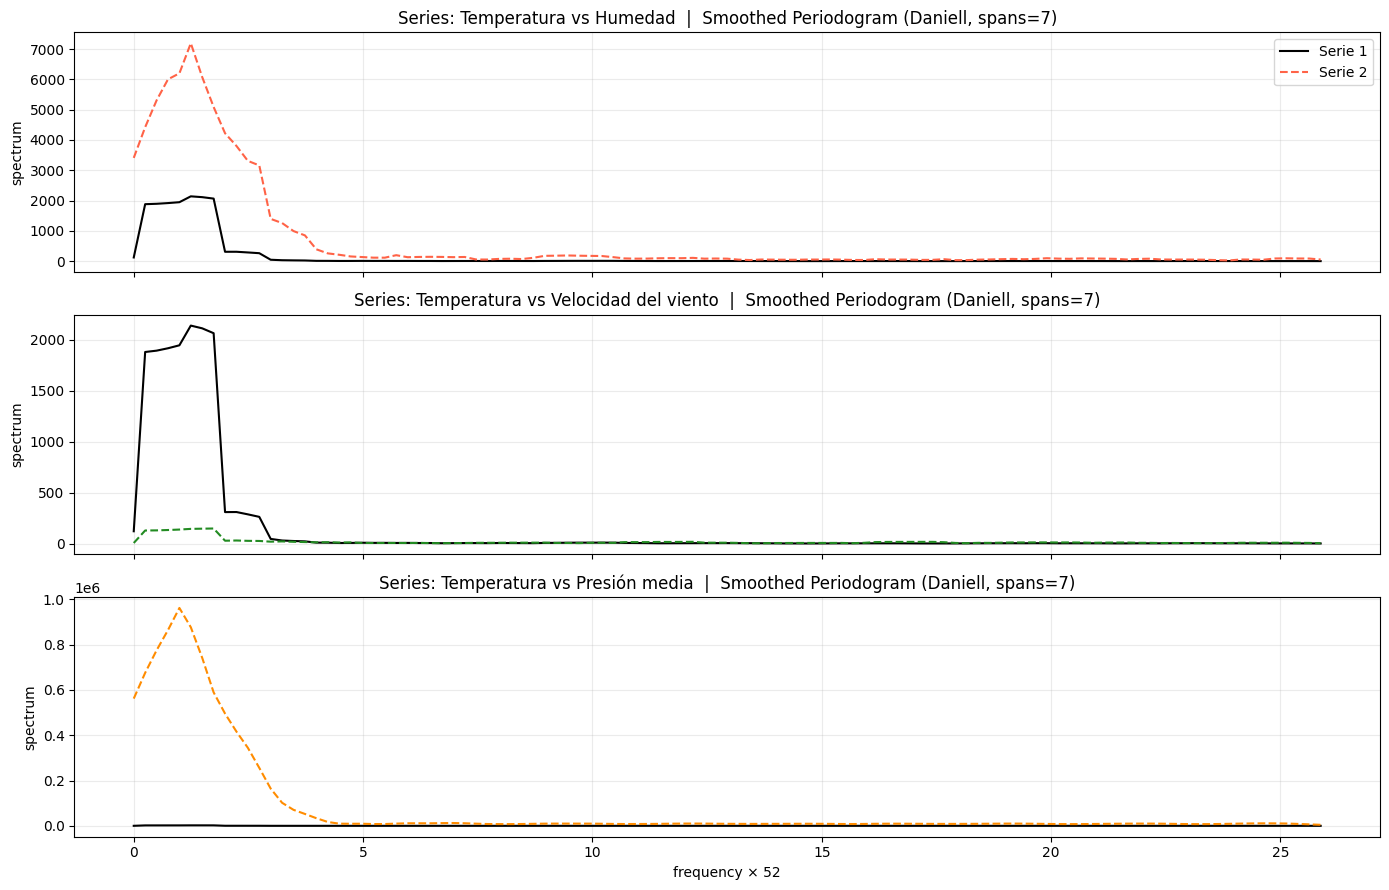

In [30]:
# --- helper: periodograma suavizado tipo Daniell ---
from scipy.signal import windows, periodogram

def smoothed_periodogram(y, fs=1.0, spans=7):
    y = np.asarray(y, dtype=float)
    # ventana Tukey ~ taper 0.1
    win = windows.tukey(len(y), alpha=0.1)
    # periodograma
    f, Pxx = periodogram(y * win, fs=fs, detrend='linear', scaling='density')
    # suavizado Daniell
    if spans > 1:
        k = np.ones(spans) / spans
        Pxx = np.convolve(Pxx, k, mode='same')
    return f, Pxx

# --- parámetros ---
spans = 7
fs = 1.0   # 1 muestra por semana
mult = 52

# --- pares a comparar (temperatura vs exógenas) ---
pairs = [
    ("Temperatura vs Humedad", ts_temp_semanal.values, ts_humedad_semanal.values, ("black", "tomato")),
    ("Temperatura vs Velocidad del viento", ts_temp_semanal.values, ts_velocidad_viento_semanal.values, ("black", "forestgreen")),
    ("Temperatura vs Presión media", ts_temp_semanal.values, ts_presion_media_semanal.values, ("black", "darkorange")),
]

fig, axes = plt.subplots(len(pairs), 1, figsize=(14, 9), sharex=True)
if len(pairs) == 1:
    axes = [axes]

for ax, (title, y1, y2, (c1, c2)) in zip(axes, pairs):
    f1, P1 = smoothed_periodogram(y1, fs=fs, spans=spans)
    f2, P2 = smoothed_periodogram(y2, fs=fs, spans=spans)

    # R suele graficar en lineal; si quieres log-y, usa ax.semilogy(...)
    ax.plot(f1 * mult, P1, color=c1, label="Serie 1")
    ax.plot(f2 * mult, P2, color=c2, linestyle="--", label="Serie 2")
    ax.set_title(f"Series: {title}  |  Smoothed Periodogram (Daniell, spans={spans})")
    ax.set_ylabel("spectrum")
    ax.grid(alpha=0.25)

axes[-1].set_xlabel("frequency × 52")
axes[0].legend(loc="upper right")
plt.tight_layout()
plt.show()

En el gr ́afico del periodo grama, se observa en la temperatura promedio semanal, humedad
promedio semanal y la velocidad del viento promedio semanal, valores altos de rezagos. Lo
que nos dice que las 3 presentan estacionalidad en aproximadamente los mismos tiempos, en
este caso seria cada 52 semanas (1 a ̃no). Tambi ́en, se intuyen comovimientos entre las series,
es decir cuando una presenta cambios las dem ́as tambi ́en lo hacen.

In [31]:
# CONFIGURAMOS LAS MATRICES
Entreno_xreg = (
    Entreno_semanal[["humidity", "wind_speed", "meanpressure"]]
    .astype(float)
    .to_numpy()
)

Testeo_xreg = (
    Testeo_semanal[["humidity", "wind_speed", "meanpressure"]]
    .astype(float)
    .to_numpy()
)

# AJUSTAMOS EL MODELO CON LAS EXÓGENAS
modelo_exogenas = SARIMAX(
    ts_temp_semanal,
    order=(1, 1, 1),
    seasonal_order=(0, 1, 1, 52),
    trend="n",
    exog=Entreno_xreg,
    enforce_stationarity=True,
    enforce_invertibility=True,
).fit(disp=False)

# Número a predecir
n_a_predecir = Testeo_xreg.shape[0]

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


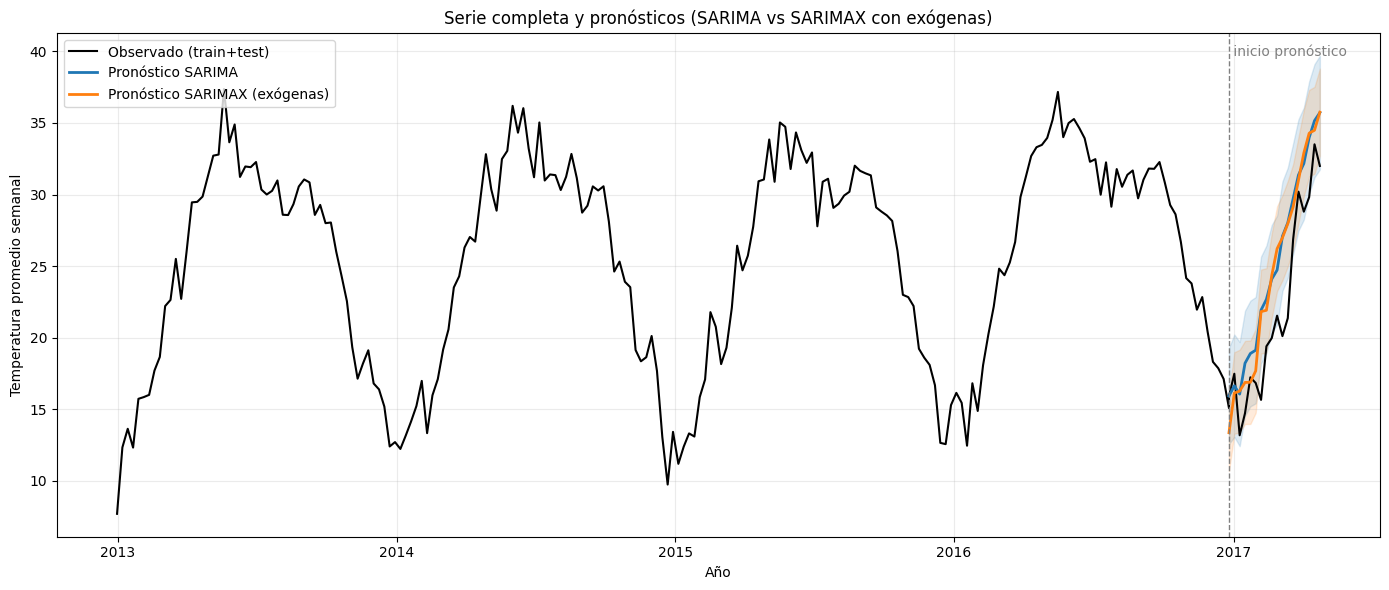

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# --- Serie completa (histórico) ---
serie_total = pd.concat([ts_temp_semanal, ts_temp_semanal_test])

# --- Pronóstico 1: SARIMA sin exógenas (si ya lo calculaste, reutiliza 'predicciones' y 'pred') ---
h = len(ts_temp_semanal_test)
pred1 = mod_sel.get_forecast(steps=h)
yhat1 = pred1.predicted_mean.copy()
ci1   = pred1.conf_int(alpha=0.05).copy()
yhat1.index = ts_temp_semanal_test.index
ci1.index   = ts_temp_semanal_test.index

pred2 = modelo_exogenas.get_forecast(steps=h, exog=Testeo_xreg)
yhat2 = pred2.predicted_mean.copy()
ci2   = pred2.conf_int(alpha=0.05).copy()
yhat2.index = ts_temp_semanal_test.index
ci2.index   = ts_temp_semanal_test.index

# --- Gráfico conjunto ---
fig, ax = plt.subplots(figsize=(14, 6))

# Histórico completo
ax.plot(serie_total.index, serie_total.values, color="black", linewidth=1.5, label="Observado (train+test)")

# Pronóstico 1: sin exógenas
ax.plot(yhat1.index, yhat1.values, color="tab:blue", linewidth=2, label="Pronóstico SARIMA")
ax.fill_between(yhat1.index, ci1.iloc[:,0].values, ci1.iloc[:,1].values, color="tab:blue", alpha=0.15)

# Pronóstico 2: con exógenas
ax.plot(yhat2.index, yhat2.values, color="tab:orange", linewidth=2, label="Pronóstico SARIMAX (exógenas)")
ax.fill_between(yhat2.index, ci2.iloc[:,0].values, ci2.iloc[:,1].values, color="tab:orange", alpha=0.15)

# Línea vertical donde comienza el pronóstico
ax.axvline(ts_temp_semanal_test.index[0], color="gray", linestyle="--", linewidth=1)
ax.text(ts_temp_semanal_test.index[0], ax.get_ylim()[1]*0.98, " inicio pronóstico ", va="top", ha="left", color="gray")

# Eje X con años
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.set_title("Serie completa y pronósticos (SARIMA vs SARIMAX con exógenas)")
ax.set_xlabel("Año")
ax.set_ylabel("Temperatura promedio semanal")
ax.legend(loc="upper left")
ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()


In [35]:
# === Resumen del modelo (equivalente a summary(modelo_exogenas) en R) ===
print(modelo_exogenas.summary())

# === Tabla de coeficientes (equivalente a summary(modelo_exogenas)$coef) ===
coefs = pd.DataFrame({
    "coef":   modelo_exogenas.params,
    "std err":modelo_exogenas.bse,
    "t/z":    modelo_exogenas.tvalues,      # t o z según el estimador
    "P>|t|":  modelo_exogenas.pvalues,
})
ci = modelo_exogenas.conf_int()
coefs["[2.5%"]  = ci.iloc[:, 0]
coefs["97.5%]"] = ci.iloc[:, 1]
print(coefs)

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  209
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 52)   Log Likelihood                -288.393
Date:                            Mon, 20 Oct 2025   AIC                            590.787
Time:                                    04:37:02   BIC                            612.136
Sample:                                12-31-2012   HQIC                           599.458
                                     - 12-26-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1278      0.017     -7.466      0.000      -0.161      -0.094
x2            -0.0694      0.054   

OBSERVAMOS QUE LA VARIABLE HUMEDAD Y TANTO LA PARTE AUTOREGRESIVA COMO MA Y LA MA ESTACIONARIA SON SIGNIFICATIVAS

In [37]:
# Residuales del modelo con exógenas
resid_exog = modelo_exogenas.resid.dropna()

# Prueba de Ljung-Box hasta el rezago 20
ljung_box_exog = acorr_ljungbox(resid_exog, lags=1, return_df=True)
print(ljung_box_exog)

    lb_stat  lb_pvalue
1  2.421618   0.119671


AHORA MIREMOS EL MAPE

In [42]:
mape_exog = mean_absolute_percentage_error(
    ts_temp_semanal_test.values,
    pred2.predicted_mean.values
) * 100

print(f"MAPE del modelo con exógenas (%): {mape_exog:.2f}")

MAPE del modelo con exógenas (%): 15.81


OBSERVAMOS MEJORA EN LA CAPACIDAD DE PRONOSTICO.